not


IndexError: list index out of range

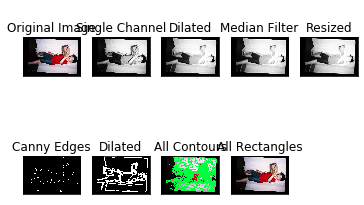

In [21]:
# usage: `python ~/Desktop/contours.py 1994-654-12_v02.tif`
# output is to a squareless.txt file and the directory "out"
# Working well with thumbnails with 400px as their longest side - untested with other dimensions

# for i in $(ls -1 | grep tif); do python /Users/artsyinc/Documents/resistance/experiments/artwork_image_cropping/contours.py $i; done

import cv2
import numpy as np
from matplotlib import pyplot as plt
import sys
import math
import pdb
import random as ra
import json
import csv

### convenience plotting functions
def ss(thing):
    cv2.imwrite("about/%s.tif" % (ra.random()), thing)
    plt.subplot(121),plt.imshow(thing,cmap = 'gray')
    plt.show()

def dd(thing, square):
    extra = thing.copy()
    cv2.drawContours(extra, [square], -1, (0,255,60), 3)
    ss(extra)
###

# Loading image
filename = "boy.jpg"

img = cv2.imread(filename)
img_copy = img.copy()[:,:,::-1] # color channel plotting mess http://stackoverflow.com/a/15074748/2256243
height = img.shape[0]
width = img.shape[1]

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15)) # matrix of ones

# https://code.google.com/p/pythonxy/source/browse/src/python/OpenCV/DOC/samples/python2/squares.py?spec=svn.xy-27.cd6bf12fae7ae496d581794b32fd9ac75b4eb366&repo=xy-27&r=cd6bf12fae7ae496d581794b32fd9ac75b4eb366
def angle_cos(p0, p1, p2):
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return abs( np.dot(d1, d2) / np.sqrt( np.dot(d1, d1)*np.dot(d2, d2) ) )

squares = []
all_contours = []

for gray in cv2.split(img):
    dilated = cv2.dilate(src = gray, kernel = kernel, anchor = (-1,-1))
    blured = cv2.medianBlur(dilated, 7)
    
    # Shrinking followed by expanding can be used for removing isolated noise pixels another way to think of it is "enlarging the background"
    #http://www.cs.umb.edu/~marc/cs675/cvs09-12.pdf
    small = cv2.pyrDown(img, dstsize =(width//2, height//2))
    oversized = cv2.pyrUp(small, dstsize = (width, height))
    
    
    #after seeing utility of later thresholds (non 0 threshold results) try instead to loop through and change thresholds in the canny filter
    # also might be interesting to store the contours in different arrays for display to color them according to the channel that they came from
    for thrs in range(0, 255, 26):
        if thrs == 0:
            edges = cv2.Canny(oversized, threshold1 = 0, threshold2 = 200, apertureSize = 3)
            _next = cv2.dilate(src = edges, kernel = kernel, anchor = (-1,-1))
        else:
            retval, _next = cv2.threshold(gray, thrs, 255, cv2.THRESH_BINARY)
        
        contours, hierarchy = cv2.findContours(_next, mode = cv2.RETR_LIST, method = cv2.CHAIN_APPROX_SIMPLE)
        
        # how are the contours sorted? outwards to inwards? would be interesting to do a PVE
        # sort of thing where the contours within a contour (and maybe see an elbow plot of some sort)
        for cnt in contours:
            all_contours.append(cnt)
            cnt_len = cv2.arcLength(cnt, True)
            cnt = cv2.approxPolyDP(cnt, 0.02*cnt_len, True)
            if len(cnt) == 4 and cv2.contourArea(cnt) > 1000 and cv2.isContourConvex(cnt):
                cnt = cnt.reshape(-1, 2)
                max_cos = np.max([angle_cos( cnt[i], cnt[(i+1) % 4], cnt[(i+2) % 4] ) for i in range(4)])
                if max_cos < 0.1:
                    squares.append(cnt)

# ranking of shapes
def rank(square):
    formatted = np.array([[s] for s in square], np.int32)
    x,y,wid,hei = cv2.boundingRect(formatted)
    max_distance_from_center = math.sqrt(((width / 2))**2 + ((height / 2))**2)
    distance_from_center = math.sqrt(((x + wid / 2) - (width / 2))**2 + ((y + hei / 2) - (height / 2))**2)

    height_above_horizontal = (height / 2) - y if y + hei > height / 2 else hei
    width_left_vertical = (width / 2) - x if x + wid > width / 2 else wid
    horizontal_score = abs(float(height_above_horizontal) / hei - 0.5) * 2
    vertical_score = abs(float(width_left_vertical) / wid - 0.5) * 2

    if cv2.contourArea(formatted) / (width * height) > 0.98:
        return 5 # max rank possible otherwise - penalize boxes that are the whole image heavily
    else:
        bounding_box = np.array([[[x,y]], [[x,y+hei]], [[x+wid,y+hei]], [[x+wid,y]]], dtype = np.int32)
        # every separate line in this addition has a max of 1
        return (distance_from_center / max_distance_from_center +
                cv2.contourArea(formatted) / cv2.contourArea(bounding_box) +
                cv2.contourArea(formatted) / (width * height) +
                horizontal_score +
                vertical_score)

sorted_squares = sorted(squares, key=lambda square: rank(square))

# visual alternative to drawing lines
def mask_image(img, square, opacity = 0.80):
    overlay = img.copy()
    cv2.fillPoly(overlay, [square], (255, 255, 255))
    inverse_overlay = cv2.bitwise_not(overlay)
    img2 = cv2.bitwise_xor(inverse_overlay, img)
    cv2.addWeighted(img2, opacity, img, 1 - opacity, 0, img)

if len(sorted_squares) and rank(sorted_squares[0]) < 3 :
    cv2.drawContours(img, squares, -1, (0,255,255), 1) # draw all found squares
    cv2.drawContours(img, [sorted_squares[0]], -1, (0,255,60), 3)
    cv2.imwrite('out/' + filename, img)
    with open('square_found.csv', 'a') as csvfile:
        writer = csv.writer(csvfile, quoting=csv.QUOTE_MINIMAL)
        writer.writerow([filename, json.dumps(sorted_squares[0].tolist()), height, width])
else:
    with open("squareless.txt", "a") as f:
        f.write(filename + "\n")
        print("not")

### Some plotting code
plt.subplot2grid((2,5), (0,0)),plt.imshow(img_copy)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
gray = cv2.split(img_copy)[0]
plt.subplot2grid((2,5), (0,1)),plt.imshow(gray, cmap = 'gray')
plt.title('\nSingle Channel'), plt.xticks([]), plt.yticks([])
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])
dilated = cv2.dilate(src = gray, kernel = kernel, anchor = (-1,-1))
plt.subplot2grid((2,5), (0,2)),plt.imshow(dilated, cmap = 'gray')
plt.title('\nDilated'), plt.xticks([]), plt.yticks([])
blured = cv2.medianBlur(dilated, 7)
plt.subplot2grid((2,5), (0,3)),plt.imshow(blured, cmap = 'gray')
plt.title('\nMedian Filter'), plt.xticks([]), plt.yticks([])

# Shrinking followed by expanding can be used for removing isolated noise pixels
# another way to think of it is "enlarging the background"
# http://www.cs.umb.edu/~marc/cs675/cvs09-12.pdf
small = cv2.pyrDown(blured, dstsize = (width // 2, height // 2))
oversized = cv2.pyrUp(small, dstsize = (width, height))
plt.subplot2grid((2,5), (0,4)),plt.imshow(oversized, cmap = 'gray')
plt.title('\nResized'), plt.xticks([]), plt.yticks([])

edges = cv2.Canny(oversized, threshold1 = 0, threshold2 = 50, apertureSize = 3)
plt.subplot2grid((2,5), (1,0)),plt.imshow(edges, cmap = 'gray')
plt.title('\nCanny Edges'), plt.xticks([]), plt.yticks([])
dilated = cv2.dilate(src = edges, kernel = kernel, anchor = (-1,-1))
plt.subplot2grid((2,5), (1,1)),plt.imshow(dilated, cmap = 'gray')
plt.title('\nDilated'), plt.xticks([]), plt.yticks([])

img_with_contours = img_copy.copy()
cv2.drawContours(img_with_contours, all_contours, -1, (0,255,60), 3)
plt.subplot2grid((2,5), (1,2)),plt.imshow(img_with_contours)
plt.title('\nAll Contours'), plt.xticks([]), plt.yticks([])

img_with_squares = img_copy.copy()
cv2.drawContours(img_with_squares, squares, -1, (0,255,60), 3)
plt.subplot2grid((2,5), (1,3)),plt.imshow(img_with_squares)
plt.title('\nAll Rectangles'), plt.xticks([]), plt.yticks([])

img_with_top_square = img_copy.copy()
cv2.drawContours(img_with_top_square, [sorted_squares[0]], -1, (0,255,60), 3)
plt.subplot2grid((2,5), (1,4)),plt.imshow(img_with_top_square)
plt.title('\nTop Ranked Shape'), plt.xticks([]), plt.yticks([])

plt.show()
